# Natural Language Processing Project
---
## **Problem Statement**
The aim of this project is to design a Natural Language Processing (NLP) framework capable of distinguishing between Fiction and Non-Fiction genre books. By processing textual input, the system extracts relevant linguistic features and leverages machine learning algorithms to carry out binary classification.

## **Expected Results**
The expected outcome is a trained and evaluated classification model capable of accurately predicting the genre of unseen book texts. The project aims to demonstrate effective text preprocessing, representation, model selection, and evaluation techniques within a real-world NLP application.

---






# Import all necessary packages


---



In [3]:
!pip -q install datasets pandas numpy matplotlib scikit-learn nltk spacy
import pandas as pd
import numpy as np
import re


In [4]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Task 2 - Selection of an Appropriate Data Set (Data Collection)
---
Two Datasets have been used.
The first one was retrieved from hugging face: : TheBritishLibrary/blbooksgenre · Datasets at Hugging Face

In [5]:
# upload main dataset
df = pd.read_csv("Raw-Book-Genre.csv", encoding="latin1") #used this because some titles use old english
print(df.shape)
df.head()  #see first 5

(1735, 3)


,BL record ID,title,label
0,14605643,An Elegy written among the ruins of an Abbey. ...,0
1,14616539,The Baron's Daughter. A ballad by the author o...,0
2,14616550,"A Little Book of Verse, etc",0
3,14616561,The Autumn Leaf Poems,0
4,14616607,"The Battle of Waterloo, a poem",0


In [6]:
df["label"].value_counts()

,count
label,
1,1301
0,434


In [7]:
#to avoid errors
df["title"] = df["title"].astype(str)

## Visualize the first dataset

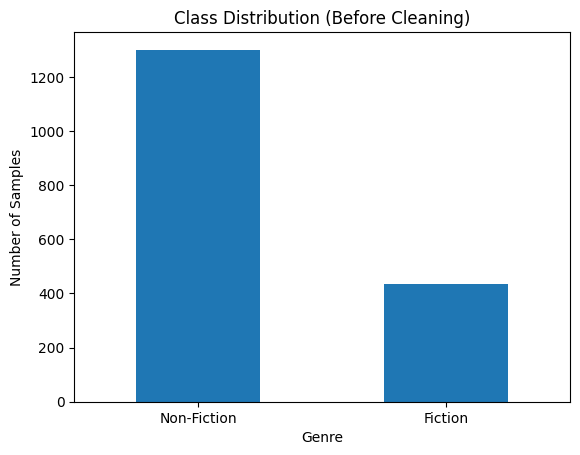

In [8]:
import matplotlib.pyplot as plt

# Map labels for readable plot
label_map = {0: "Fiction", 1: "Non-Fiction"}
df["genre_text"] = df["label"].map(label_map)

counts = df["genre_text"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Class Distribution (Before Cleaning)")
plt.xlabel("Genre")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()


## The second dataset was retrived through OpenLibrary

In [9]:
df_new = pd.read_csv("fiction_750_openlibrary.csv", encoding="utf-8")  # if it errors try latin1/cp1252
print("New shape:", df_new.shape)
print(df_new.columns)
df_new.head()


New shape: (750, 2)
Index(['book_title', 'genre'], dtype='object')


,book_title,genre
0,The Iron Heel,Fiction
1,Brood of the Witch-Queen,Fiction
2,The Napoleon of Notting Hill,Fiction
3,Emily of New Moon,Fiction
4,The Sea Fairies,Fiction


## Adjust both datasets and merge into one

In [10]:
# Rename to match main dataset
df_new = df_new.rename(columns={"book_title": "title", "genre": "genre_text"}).copy()

# Clean title
df_new["title"] = df_new["title"].astype(str).str.strip()
df_new = df_new[df_new["title"].str.len() > 0]

# Map labels
label_map = {
    "Fiction": 0,
    "Non-Fiction": 1,
    "Non Fiction": 1,      # just in case formatting differs
    "Nonfiction": 1
}

df_new["label"] = df_new["genre_text"].map(label_map)

# Drop anything that didn't map
df_new = df_new.dropna(subset=["label"])
df_new["label"] = df_new["label"].astype(int)

# Keep only the same columns as the original
df_new = df_new[["title", "label"]].copy()

print("New (standardized) shape:", df_new.shape)
df_new["label"].value_counts()


New (standardized) shape: (750, 2)


,count
label,
0,750


In [11]:
#Merge the two datasets into one:

df_merged = pd.concat([df, df_new], ignore_index=True)

# Normalize titles for deduplication
df_merged["title_norm"] = (
    df_merged["title"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

before = df_merged.shape[0]
df_merged = df_merged.drop_duplicates(subset=["title_norm"]).drop(columns=["title_norm"])
after = df_merged.shape[0]

print("Merged shape:", df_merged.shape)
print("Removed duplicates:", before - after)
print(df_merged["label"].value_counts())
df_merged.head()


Merged shape: (2483, 4)
Removed duplicates: 2
label
1    1301
0    1182
Name: count, dtype: int64


,BL record ID,title,label,genre_text
0,14605643.0,An Elegy written among the ruins of an Abbey. ...,0,Fiction
1,14616539.0,The Baron's Daughter. A ballad by the author o...,0,Fiction
2,14616550.0,"A Little Book of Verse, etc",0,Fiction
3,14616561.0,The Autumn Leaf Poems,0,Fiction
4,14616607.0,"The Battle of Waterloo, a poem",0,Fiction


In [12]:
df = df_merged.copy()

X = df["title"]
y = df["label"]


## Visualize the new merged dataset

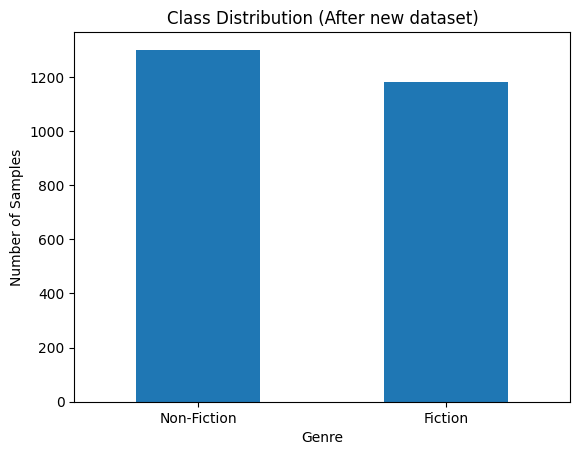

In [13]:
label_map = {0: "Fiction", 1: "Non-Fiction"}
df["genre_text"] = df["label"].map(label_map)

counts = df["genre_text"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Class Distribution (After new dataset)")
plt.xlabel("Genre")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()


## Cleaning & prepare the features/labels


*   Keep only the necessary columns (title, label)

*   Remove missing / empty titles
*   To ensure the types are correct

*   Create X (text) and y (labels)

In [14]:
#  Keep only the necessary columns (title, label)
df = df[["title", "label"]].copy()

# Remove missing titles/labels
df = df.dropna(subset=["title", "label"])

# To ensure correct types
df["title"] = df["title"].astype(str).str.strip()
df = df[df["title"].str.len() > 0]

# Labels
df["label"] = df["label"].astype(int)

X = df["title"]
y = df["label"]

print(df.shape)
print(df["label"].value_counts())
df.head()


(2483, 2)
label
1    1301
0    1182
Name: count, dtype: int64


,title,label
0,An Elegy written among the ruins of an Abbey. ...,0
1,The Baron's Daughter. A ballad by the author o...,0
2,"A Little Book of Verse, etc",0
3,The Autumn Leaf Poems,0
4,"The Battle of Waterloo, a poem",0


## Train / Validation / Test split

splits data into:

*   Train
*   Validation
*   Test

In [15]:


from sklearn.model_selection import train_test_split

# First split: train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(len(X_train), len(X_val), len(X_test))


1738 372 373


# Task 3 –Text Preprocessing


---
This section will:


*   Apply Lemmatization
*   Apply Tokenization


*   Vectorize using TD-IDF


*   Remove extra whitespace
*   Convert to Lowercase


*   Remove weird punctuation
*   remove stopwords




In [17]:
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def clean_tokenize_lemmatize(text: str) -> str:
    text = str(text).lower() #lowercase
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)                 #tokenization
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]  # lemmatization

    return " ".join(lemmas)

X_train_clean = X_train.apply(clean_tokenize_lemmatize)
X_val_clean   = X_val.apply(clean_tokenize_lemmatize)
X_test_clean  = X_test.apply(clean_tokenize_lemmatize)

X_train_clean.head(10)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,title
891,aanteekeningen over het dorp stramproy eene bi...
102,the love affair of an old maid
587,short story for long journey
1747,the canterville ghost
576,ramble and research in thuringian saxony
352,a history of the parish of leyton essex with m...
522,the little duke or richard the fearless by the...
2397,alias grace
2007,and then there were none
1705,cr nica de la araucan a etc


In [18]:
#Vectorization using TF-IDF (turn text into numbers)
#Use English stopwords to remove common words

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_vec = tfidf.fit_transform(X_train_clean)  # fit on train
X_val_vec   = tfidf.transform(X_val_clean)        # transform val
X_test_vec  = tfidf.transform(X_test_clean)       # transform test

print("Train:", X_train_vec.shape)
print("Val:  ", X_val_vec.shape)
print("Test: ", X_test_vec.shape)



Train: (1738, 2021)
Val:   (372, 2021)
Test:  (373, 2021)


# Task 4- Text Representation


---
This section will implement:


*   Bag of Words (BoW) as CountVectorizer
*   N-grams as Bigram BoW


*   POS tagging







In [19]:
from sklearn.feature_extraction.text import CountVectorizer    #BOW

bow = CountVectorizer(
    stop_words="english"
)

X_train_bow = bow.fit_transform(X_train_clean)
X_val_bow   = bow.transform(X_val_clean)
X_test_bow  = bow.transform(X_test_clean)

print("BoW shapes:", X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)

# Show a few feature names for report
print("Sample BoW features:", bow.get_feature_names_out()[:25])


BoW shapes: (1738, 5646) (372, 5646) (373, 5646)
Sample BoW features: ['10' '100' '1000' '105' '1066' '11' '110' '1179' '12' '120' '1204' '1223'
 '124' '1299' '13' '1319' '1326' '1345' '1346' '1350' '1363' '13de' '14'
 '1401' '1439']


In [20]:
ngram_bow = CountVectorizer(      #N-grams
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

X_train_ng = ngram_bow.fit_transform(X_train_clean)
X_val_ng   = ngram_bow.transform(X_val_clean)
X_test_ng  = ngram_bow.transform(X_test_clean)

print("N-gram shape:", X_train_ng.shape)
print("Sample n-grams:", ngram_bow.get_feature_names_out()[:20])



N-gram shape: (1738, 2021)
Sample n-grams: ['100' '12' '14' '15' '1564' '1566' '1568' '1574' '1575' '1585' '1594'
 '1612' '1648' '1658' '1670' '1672' '1672 en' '1673' '1679' '1680']


In [22]:
#POS tagging
nltk.download('averaged_perceptron_tagger_eng')
nltk.download("averaged_perceptron_tagger")

from nltk import pos_tag, word_tokenize

sample = X_train_clean.iloc[0]
tags = pos_tag(word_tokenize(sample))
print("Sample text:", sample)
print("POS tags:", tags[:15])


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Sample text: aanteekeningen over het dorp stramproy eene bijdrage tot de geschiedenis van het voormalig rijksvorstendom thorn
POS tags: [('aanteekeningen', 'NN'), ('over', 'IN'), ('het', 'JJ'), ('dorp', 'JJ'), ('stramproy', 'NN'), ('eene', 'NN'), ('bijdrage', 'NN'), ('tot', 'NN'), ('de', 'IN'), ('geschiedenis', 'FW'), ('van', 'FW'), ('het', 'NN'), ('voormalig', 'NN'), ('rijksvorstendom', 'NN'), ('thorn', 'NN')]


# Task 5 –Text Classification / Prediction


---
For this section, Naive Bayes and Logistic Regression will be used.

Naive Bayes was chosen as a baseline model due to its efficiency and strong performance in text-based tasks, while Logistic Regression was selected as an improved classifier capable of learning more expressive decision boundaries. Together, these models effectively address the Fiction vs. Non-Fiction classification problem and provide meaningful insights into model performance trade-offs.




## Model 1: Naive Bayes
This model will:


*   Train a simple text classifier
*   Predict labels and probabilities

In [31]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
nb_val_pred = nb.predict(X_val_vec)
nb_pred = nb.predict(X_test_vec)



## Model 2: Logistic Regression
This model will:



*   Train a linear classifier that uses TF-IDF features
*   Predict labels and probabilities

In [32]:
from sklearn.linear_model import LogisticRegression

lr_bal = LogisticRegression(max_iter=2000, class_weight="balanced")
lr_bal.fit(X_train_vec, y_train)
lr_val_pred = lr_bal.predict(X_val_vec)
lr_pred = lr_bal.predict(X_test_vec)


# Task 6 – Evaluation

---
Multiple evaluation methods will be applied in this section.


## 1- Naive Bayes (VAL) confusion matrix

Evaluate Naive Bayes on the validation set (VAL) while testing/choosing models.




Naive Bayes (VAL)
              precision    recall  f1-score   support

     Fiction       0.85      0.45      0.59       177
 Non-Fiction       0.65      0.93      0.77       195

    accuracy                           0.70       372
   macro avg       0.75      0.69      0.68       372
weighted avg       0.75      0.70      0.68       372



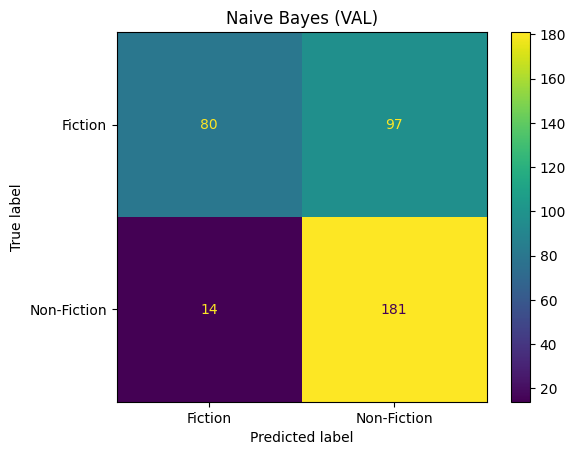

Logistic Regression Balanced (VAL)
              precision    recall  f1-score   support

     Fiction       0.89      0.86      0.88       177
 Non-Fiction       0.88      0.90      0.89       195

    accuracy                           0.88       372
   macro avg       0.88      0.88      0.88       372
weighted avg       0.88      0.88      0.88       372



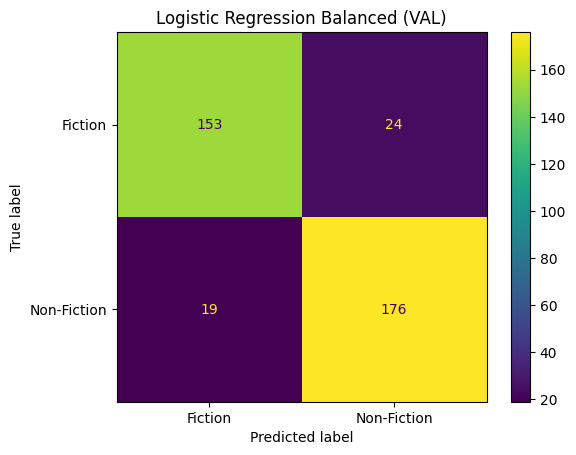

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred):
    print("="*60)
    print(name)
    print(classification_report(y_true, y_pred, target_names=["Fiction", "Non-Fiction"]))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Fiction", "Non-Fiction"]).plot()
    plt.title(name)
    plt.show()

evaluate_model("Naive Bayes (VAL)", y_val, nb_val_pred)
evaluate_model("Logistic Regression Balanced (VAL)", y_val, lr_val_pred)




---


This confusion matrix shows Naive Bayes performance on the validation set. It was used as a baseline model to compare against Logistic Regression before selecting the final approach.


---



## 2- Naive Bayes (TF-IDF) confusion matrix

This one shows NB on the test set using TF-IDF features.

It demonstrates the baseline model on the final unseen test data.

Shows how the model will work on unseen data


Naive Bayes (TF-IDF)
Accuracy: 0.7560321715817694
F1: 0.7991169977924945
              precision    recall  f1-score   support

     Fiction       0.88      0.57      0.69       178
 Non-Fiction       0.70      0.93      0.80       195

    accuracy                           0.76       373
   macro avg       0.79      0.75      0.74       373
weighted avg       0.79      0.76      0.75       373



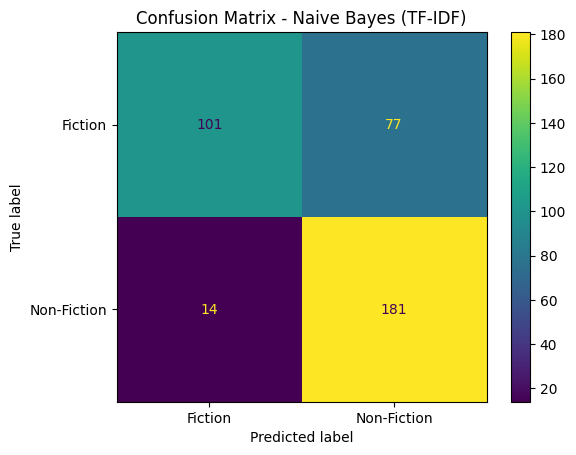

Logistic Regression (TF-IDF)
Accuracy: 0.871313672922252
F1: 0.8723404255319149
              precision    recall  f1-score   support

     Fiction       0.84      0.90      0.87       178
 Non-Fiction       0.91      0.84      0.87       195

    accuracy                           0.87       373
   macro avg       0.87      0.87      0.87       373
weighted avg       0.87      0.87      0.87       373



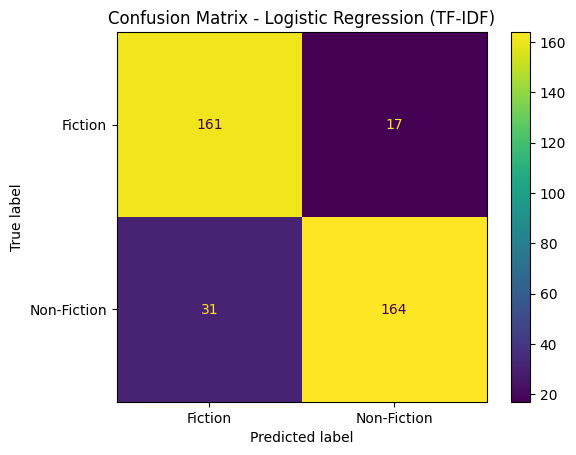

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred):
    print("="*60)
    print(name)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["Fiction", "Non-Fiction"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fiction", "Non-Fiction"])
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

evaluate_model("Naive Bayes (TF-IDF)", y_test, nb_pred)
evaluate_model("Logistic Regression (TF-IDF)", y_test, lr_pred)




---

This confusion matrix shows Naive Bayes results on the test set using TF-IDF vectors. It highlights how often the model misclassified Fiction titles as Non-Fiction and vice versa.


---



## 3- Logistic Regression (balanced) confusion matrix

This is the best confusion matrix. It’s the most important one because it represents the final performance on unseen test data, and it uses class_weight="balanced" to handle class imbalance.



Logistic Regression (balanced) - TEST
Accuracy: 0.871313672922252
F1: 0.8723404255319149
              precision    recall  f1-score   support

     Fiction       0.84      0.90      0.87       178
 Non-Fiction       0.91      0.84      0.87       195

    accuracy                           0.87       373
   macro avg       0.87      0.87      0.87       373
weighted avg       0.87      0.87      0.87       373



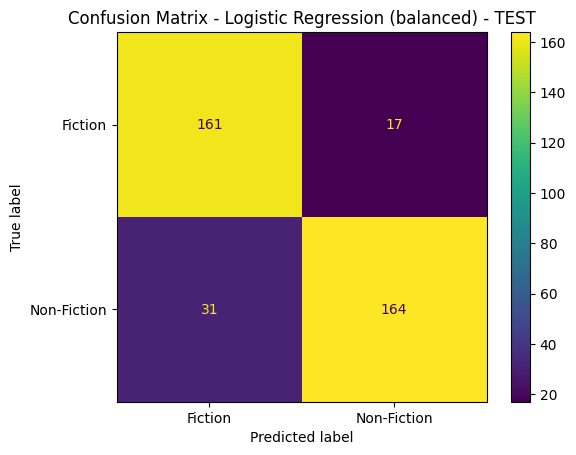

Macro F1 (TEST): 0.8713053479010926
Balanced Acc (TEST): 0.8727600115240565
ROC-AUC (TEST): 0.9421636416018437


In [36]:
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score

lr_test_pred = lr_bal.predict(X_test_vec)
lr_test_proba = lr_bal.predict_proba(X_test_vec)[:, 1]

evaluate_model("Logistic Regression (balanced) - TEST", y_test, lr_test_pred)

print("Macro F1 (TEST):", f1_score(y_test, lr_test_pred, average="macro"))
print("Balanced Acc (TEST):", balanced_accuracy_score(y_test, lr_test_pred))
print("ROC-AUC (TEST):", roc_auc_score(y_test, lr_test_proba))




---


This confusion matrix shows the final Logistic Regression model on the test set. Using balanced class weights improved fairness between classes and reduced bias toward the majority class.


---



In [46]:
# This will esnure model is working and ensure model is fitted
lr_bal = LogisticRegression(max_iter=2000, class_weight="balanced")
lr_bal.fit(X_train_vec, y_train)

#This creates probabilities (will be used later for GUI)
lr_bal_proba = lr_bal.predict_proba(X_test_vec)[:, 1]


## Comparison table

In [37]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results_val = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression (balanced)"],
    "Accuracy": [
        accuracy_score(y_val, nb_val_pred),
        accuracy_score(y_val, lr_val_pred)
    ],
    "F1_macro": [
        f1_score(y_val, nb_val_pred, average="macro"),
        f1_score(y_val, lr_val_pred, average="macro")
    ]
}).sort_values(by="F1_macro", ascending=False)

results_val


,Model,Accuracy,F1_macro
1,Logistic Regression (balanced),0.884409,0.883965
0,Naive Bayes,0.701613,0.677867


## Additional Evaluation

Adds Macro-F1, Balanced Accuracy, ROC-AUC.

In [38]:

from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score

nb_val_proba = nb.predict_proba(X_val_vec)[:, 1]
lr_val_proba = lr_bal.predict_proba(X_val_vec)[:, 1]

print("NB macro F1 (VAL):", f1_score(y_val, nb_val_pred, average="macro"))
print("LR macro F1 (VAL):", f1_score(y_val, lr_val_pred, average="macro"))

print("NB balanced acc (VAL):", balanced_accuracy_score(y_val, nb_val_pred))
print("LR balanced acc (VAL):", balanced_accuracy_score(y_val, lr_val_pred))

print("NB ROC-AUC (VAL):", roc_auc_score(y_val, nb_val_proba))
print("LR ROC-AUC (VAL):", roc_auc_score(y_val, lr_val_proba))



NB macro F1 (VAL): 0.6778667998096471
LR macro F1 (VAL): 0.8839650357259439
NB balanced acc (VAL): 0.6900912646675359
LR balanced acc (VAL): 0.8834854411125598
NB ROC-AUC (VAL): 0.9029986962190352
LR ROC-AUC (VAL): 0.9339997102708968


## Error analysis
This is to deal with wrong predictions that can happen due to mislabel, generic words,etc.


In [39]:


test_df = pd.DataFrame({
    "title": X_test,
    "true": y_test.values,
    "pred": lr_test_pred
})

# wrong predictions
wrong = test_df[test_df["true"] != test_df["pred"]].copy()
wrong["true_label"] = wrong["true"].map({0: "Fiction", 1: "Non-Fiction"})
wrong["pred_label"] = wrong["pred"].map({0: "Fiction", 1: "Non-Fiction"})

wrong.head(20)



,title,true,pred,true_label,pred_label
1479,Kurhessen seit dem Freiheitskriege,1,0,Non-Fiction,Fiction
55,On a plastic operation for the restoration of ...,1,0,Non-Fiction,Fiction
273,The book of the Thames,1,0,Non-Fiction,Fiction
702,"Deutsche Arbeit am Njasza, Deutsch-Ostafrika",1,0,Non-Fiction,Fiction
1261,Parijs tijdens de Roode Terreur,1,0,Non-Fiction,Fiction
1678,Journal of Army Life,1,0,Non-Fiction,Fiction
1336,De Strijd onzer Vaderen tegen Spanje ... Tweed...,1,0,Non-Fiction,Fiction
1443,Die Entstehung des sterreichischen Deutschthums,1,0,Non-Fiction,Fiction
2035,The history of the great plague in London in t...,0,1,Fiction,Non-Fiction
682,Lose Bltter aus dem Orient,1,0,Non-Fiction,Fiction


## Threshold Tuning (For GUI)

Since I want the GUI to show probability, I will be implementing this threshold

In [47]:

from sklearn.metrics import precision_recall_fscore_support

thresholds = np.arange(0.1, 0.9, 0.05)

best = None
for t in thresholds:
    pred_t = (lr_bal_proba >= t).astype(int)
    macro_f1 = f1_score(y_test, pred_t, average="macro")
    if best is None or macro_f1 > best[0]:
        best = (macro_f1, t)

print("Best macro F1:", best[0], "at threshold:", best[1])


Best macro F1: 0.9106962773791472 at threshold: 0.40000000000000013


LR balanced + threshold=0.40
Accuracy: 0.9115281501340483
F1: 0.9193154034229829
              precision    recall  f1-score   support

     Fiction       0.96      0.85      0.90       178
 Non-Fiction       0.88      0.96      0.92       195

    accuracy                           0.91       373
   macro avg       0.92      0.91      0.91       373
weighted avg       0.92      0.91      0.91       373



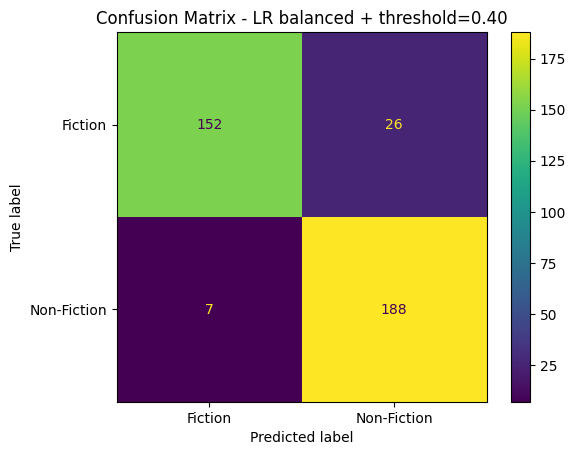

In [48]:
#Applied whatever we did in the above step
best_t = best[1]
lr_tuned_pred = (lr_bal_proba >= best_t).astype(int)

evaluate_model(f"LR balanced + threshold={best_t:.2f}", y_test, lr_tuned_pred)


Save trained model
Incase, I will be using these later on.

In [49]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(lr_bal, "genre_model.joblib")
joblib.dump(best_t, "best_threshold.joblib")


['best_threshold.joblib']

# Implementation of GUI

In [42]:
!pip install gradio

GUI implemented using Gradio.
Will allow user to enter a book title and predict if it is a Fictional or non-fictional book. Moreover, it will give a probability of it being a non-fiction book.

In [50]:
import gradio as gr
import joblib
import re

# load artifacts
tfidf = joblib.load("tfidf_vectorizer.joblib")
model = joblib.load("genre_model.joblib")
threshold = joblib.load("best_threshold.joblib")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def predict_genre(title):
    title_clean = clean_text(title)
    vec = tfidf.transform([title_clean])
    proba = model.predict_proba(vec)[0][1]  # Non-Fiction prob
    label = "Non-Fiction" if proba >= threshold else "Fiction"
    return label, round(float(proba), 3)

interface = gr.Interface(
    fn=predict_genre,
    inputs=gr.Textbox(lines=2, placeholder="Enter a book title"),
    outputs=[
        gr.Text(label="Predicted Genre"),
        gr.Number(label="Non-Fiction Probability")
    ],
    title="Book Genre Classification",
    description="TF-IDF + Logistic Regression model trained on British Library data"
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a0f65c3eba0d12a00a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
